In [1]:
import sys
sys.path.append('../')

from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack, hstack, join, unique
from astroquery.simbad import Simbad

from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
# Fix glob square bracket issue
to_replace = {'[':'[[]',
              ']':'[]]'}

In [4]:
# Associate Source files with nearsest SIMBAD ID
src_region_dict = get_src_region_dict()

Getting source region dict


In [5]:
xrt_colnames1 = ['MJD', 'T_+ve', 'T_-ve', 'Rate', 'Ratepos', 'Rateneg', 'obsID'] # From full band qdp files
xrt_colnames2 = ['MJD', 'Err (pos)', 'Err(neg)', 'Rate', 'Error', 'obsID']       # From soft/hard/hr qdp files

col_names = ['SIMBAD_ID', 'LOCAL_ID', 'READABLE_NAME', 'N_MAGHIST', 'N_UVOTSOURCE', 'N_CSV', 'SRC_REG']
print(f'{col_names[0]:<30} {col_names[1]:<20} {col_names[2]:<20} {col_names[3]:<10} {col_names[4]:<12} {col_names[5]:<10} {col_names[6]:<10}')

all_lcs = {}
for simbad_name, local_name in source_names_dict.items():
    readable_name = source_names_readable[simbad_name]
    
    lcs = {}
    
    src_reg = src_region_dict[simbad_name]
    src_reg_stem = src_reg.split('/')[-1].split('.')[0]+'_'
    
    
    simbad_name_glob = simbad_name.translate(str.maketrans(to_replace)) # Used to fix globbing square brackets
    
    uvotsource_files = glob(f'../download_scripts/{local_name}/*uvotsource_all.fits')
    maghist_files    = glob(f'../download_scripts/{local_name}/*maghist_all.fits*')
    csv_files        = glob(f'../UKSSDC/{simbad_name_glob}/*/*/*.csv')
    
    all_tables = []
    
    for csv in csv_files:
        tab = Table.from_pandas(pd.read_csv(csv, dtype={'obsID':str}))
        all_tables.append(tab)

        if tab.colnames == xrt_colnames1:
            new_names = ['MJD', 'MJD_ERR_POS', 'MJD_ERR_NEG', 'RATE', 'RATE_ERR_POS', 'RATE_ERR_NEG', 'OBSID']
            tab.rename_columns(xrt_colnames1, new_names)
            tab['RATE_ERR'] = tab['RATE_ERR_POS'] + abs(tab['RATE_ERR_NEG'])
            
        if tab.colnames == xrt_colnames2:
            new_names = ['MJD', 'MJD_ERR_POS', 'MJD_ERR_NEG', 'RATE', 'RATE_ERR', 'OBSID']
            tab.rename_columns(xrt_colnames2, new_names)
            

        if 'curve' in csv:
            key = 'XRT_FULL'
        if 'HARD' in csv:
            key = 'XRT_HARD'
        if 'SOFT' in csv:
            key = 'XRT_SOFT'
        if 'HR' in csv:
            key = 'XRT_HR'
        if 'PC' in csv:
            key += '_PC'
        if 'WT' in csv:
            key += '_WT'
        lcs[key] = tab
        
            

    for maghist in maghist_files:
        if src_reg_stem in maghist:
            # print(src_reg_stem, maghist)
            tab = Table.read(maghist)
            for f in np.unique(tab['FILTER']):
                sub = tab[tab['FILTER'] == f]
                lcs[f'UVOT_{f}'] = sub

    all_lcs[simbad_name] = lcs
    
    if simbad_name in source_names_w_counterparts:
        simbad_name+='*'
        local_name+='*'
        readable_name+='*'
    print(f'{simbad_name:<30} {local_name:<20} {readable_name:<20} {len(maghist_files):<10} {len(uvotsource_files):<12} {len(csv_files):<8} {src_reg_stem:<10}')
    
    

SIMBAD_ID                      LOCAL_ID             READABLE_NAME        N_MAGHIST  N_UVOTSOURCE N_CSV      SRC_REG   
ESO_243-49_HLX-1               ESO243-49            ESO_243-49 HLX-1     1          0            4        src_      
NAME_Holmberg_IX_X-1           Holmberg_IX          Holmberg IX X-1      1          1            5        src_      
Holmberg_II_X-1*               Holmberg_II*         Holmberg II X-1*     1          1            4        src_      
M31_ULX-1                      M31                  M31 ULX-1            1          1            0        src_      
[LM2005]_NGC_598_ULX1*         M33*                 M33 ULX-1*           1          1            8        src_      
RX_J133001+47137*              M51*                 M51 ULX-7*           1          1            4        ULX7_src_ 
[LM2005]_NGC_3031_ULX1         M81                  M81 ULX-1            1          2            5        ULX1_src_ 
M82_X-2                        M82                  M82 X-2   

In [6]:
print('PRE-PROCESSING LIGHT CURVES...')
print('------------------------------')

colnames = ['SIMBAD_NAME', 'LC_NAME', 'LC_LENGTH','N_OBS','UVOT_EXPOSURE']
print(f'{colnames[0]:<40} {colnames[1]:<20} {colnames[2]:<10} {colnames[3]:<10} {colnames[4]:<10}')
for simbad_name, lcs in all_lcs.items():
    for lc_name, tab in lcs.items():
        
        N_obs = len(np.unique(tab['OBSID']))
        lc_len = len(tab)
        
        if 'UVOT' in lc_name:
            tab['FLAG_AB_MAG_99'] = tab['AB_MAG'] == 99
            tab['FLAG_UPPER_LIM'] = tab['NSIGMA'] < tab['MAG_LIM_SIG'] 
            tab['FLAG_AB_MAG_ERR>2'] = tab['AB_MAG_ERR'] > 2
            tab['FLAG_AB_MAG_>10_<30'] = np.logical_or((tab['AB_MAG'] < 10), (tab['AB_MAG'] > 30))
            
            nsig = 1
            sig_upper = np.mean(tab['AB_MAG']) + nsig*np.std(tab['AB_MAG'])
            sig_lower = np.mean(tab['AB_MAG']) - nsig*np.std(tab['AB_MAG'])
            tab['FLAG_AB_MAG_>1_SIG'] = np.logical_or((tab['AB_MAG'] < sig_lower), (tab['AB_MAG'] > sig_upper))
            
            uvot_exposure = sum(tab['EXPOSURE'])
        
        if 'XRT' in lc_name:
            tab['FLAG_RATE_0'] = tab['RATE'] < 0.0001
            uvot_exposure = 0
        all_lcs[simbad_name][lc_name] = tab
        

        #if N_obs > 200:
        print(f'{simbad_name:<40} {lc_name:<20} {lc_len:<10} {N_obs:<10} {uvot_exposure:.2f}')

PRE-PROCESSING LIGHT CURVES...
------------------------------
SIMBAD_NAME                              LC_NAME              LC_LENGTH  N_OBS      UVOT_EXPOSURE
ESO_243-49_HLX-1                         XRT_FULL_PC          146        146        0.00
ESO_243-49_HLX-1                         XRT_HARD_PC          146        146        0.00
ESO_243-49_HLX-1                         XRT_HR_PC            146        146        0.00
ESO_243-49_HLX-1                         XRT_SOFT_PC          146        146        0.00
ESO_243-49_HLX-1                         UVOT_B               1          1          95.24
ESO_243-49_HLX-1                         UVOT_U               298        148        220603.31
ESO_243-49_HLX-1                         UVOT_UVM2            293        153        218239.42
ESO_243-49_HLX-1                         UVOT_UVW1            245        105        156665.12
ESO_243-49_HLX-1                         UVOT_UVW2            639        242        504937.44
ESO_243-49_HLX-1  

In [7]:
print('APPLYING FILTER FLAGS')
print('---------------------')

for simbad_name, lcs in all_lcs.items():
    for lc_name, tab in lcs.items():
        if 'UVOT' in lc_name:
            flags = ['FLAG_AB_MAG_99', 'FLAG_UPPER_LIM', 'FLAG_AB_MAG_>10_<30', 'FLAG_AB_MAG_ERR>2', 'FLAG_AB_MAG_>1_SIG', ]
            colors = ['red', 'blue', 'purple', 'green']

        elif 'XRT' in lc_name:
            flags = ['FLAG_RATE_0']
            colors = ['green']

            #plt.figure(figsize=(20,5))
            #plt.errorbar(tab['MET'], tab['AB_MAG'], yerr=tab['AB_MAG_ERR'], ls='none', lw=1.0, capsize=1.0, marker='.')

            
        for i, flag in enumerate(flags):
            rows_pre = len(tab)
            tab = tab[~tab[flag]]
            all_lcs[simbad_name][lc_name] = tab
            print(f'{simbad_name:<40}{lc_name:<20}{flag:<20} pre={rows_pre:<5} post={len(tab):<5} diff={rows_pre-len(tab):<5}')

            #plt.figure(figsize=(20,5))
            #plt.title(f'{simbad_name:<40}{lc_name:<20}{flag:<20} \n pre={rows_pre:<5} post={len(tab):<5} diff={rows_pre-len(tab):<5}')
            #plt.errorbar(tab['MET'], tab['AB_MAG'], yerr=tab['AB_MAG_ERR'], ls='none', lw=1.0, capsize=1.0, marker='.', color=colors[i])
            #plt.show()

APPLYING FILTER FLAGS
---------------------
ESO_243-49_HLX-1                        XRT_FULL_PC         FLAG_RATE_0          pre=146   post=144   diff=2    
ESO_243-49_HLX-1                        XRT_HARD_PC         FLAG_RATE_0          pre=146   post=124   diff=22   
ESO_243-49_HLX-1                        XRT_HR_PC           FLAG_RATE_0          pre=146   post=126   diff=20   
ESO_243-49_HLX-1                        XRT_SOFT_PC         FLAG_RATE_0          pre=146   post=144   diff=2    
ESO_243-49_HLX-1                        UVOT_B              FLAG_AB_MAG_99       pre=1     post=1     diff=0    
ESO_243-49_HLX-1                        UVOT_B              FLAG_UPPER_LIM       pre=1     post=1     diff=0    
ESO_243-49_HLX-1                        UVOT_B              FLAG_AB_MAG_>10_<30  pre=1     post=1     diff=0    
ESO_243-49_HLX-1                        UVOT_B              FLAG_AB_MAG_ERR>2    pre=1     post=1     diff=0    
ESO_243-49_HLX-1                        UVOT_B      

In [8]:
all_lcs.keys()

dict_keys(['ESO_243-49_HLX-1', 'NAME_Holmberg_IX_X-1', 'Holmberg_II_X-1', 'M31_ULX-1', '[LM2005]_NGC_598_ULX1', 'RX_J133001+47137', '[LM2005]_NGC_3031_ULX1', 'M82_X-2', '[LM2005]_NGC_1042_ULX1', 'NAME_NGC_1313_X-1', 'NAME_NGC_1313_X-2', '[LM2005]_NGC_247_ULX1', '[LB2005]_NGC_253_X2', '[LB2005]_NGC_253_X9', 'NAME_NGC_300_ULX1', '[LM2005]_NGC_4395_ULX1', '[LM2005]_NGC_5204_ULX1', '[LM2005]_NGC_5408_ULX1', '[SRW2006b]_NGC_55_ULX', '[SST2011]_J141939.39+564137.8', 'NAME_NGC_5907_ULX', '[LB2005]_NGC_6946_ULX1', '[LB2005]_NGC_6946_ULX3', 'NAME_NGC_7090_ULX3', 'NAME_NGC_7793_P13', 'NAME_NGC_925_ULX-1', 'NAME_NGC_925_ULX-2', 'SMC_X-3', 'SS433', 'SWIFT_J0243.6+6124', 'NAME_UGC_6456_ULX', 'NOVA_Cyg_1989', '[LB2005]_NGC_5236_X11', 'NAME_M83_ULX-1', 'NAME_NGC_1365-X1', '[SK2009]_X2', 'NAME_IC_10_X-1', '[WMR2006]_NGC4945_XMM1', '[LB2005]_NGC_3031_X6', '[LM2005]_NGC_4559_ULX1'])

In [9]:
from astropy.time import Time

In [10]:
source_gtis = {'NAME_Holmberg_IX_X-1'   : [(54750,55750), (55800,56900),  (59000,59400)],
               'RX_J133001+47137'       : [(58100,59800)],
               '[LM2005]_NGC_3031_ULX1' : [(54750,55750), (55800,57000)],
               'M82_X-2'                : [(56000, 59050)],
               'NAME_NGC_1313_X-1'      : [(56350,59550)],
               'NAME_NGC_1313_X-2'      : [(56350,59550)],
               '[LM2005]_NGC_5408_ULX1' : [(54500,56200)],
               '[LM2005]_NGC_4395_ULX1' : [(54500,55000)],
               'NAME_IC_10_X-1'         : [(58500,59800)],
               'NAME_NGC_7793_P13'      : [(57500,59000)],
               'NAME_NGC_925_ULX-1'     : [(58500,59800)],
               }

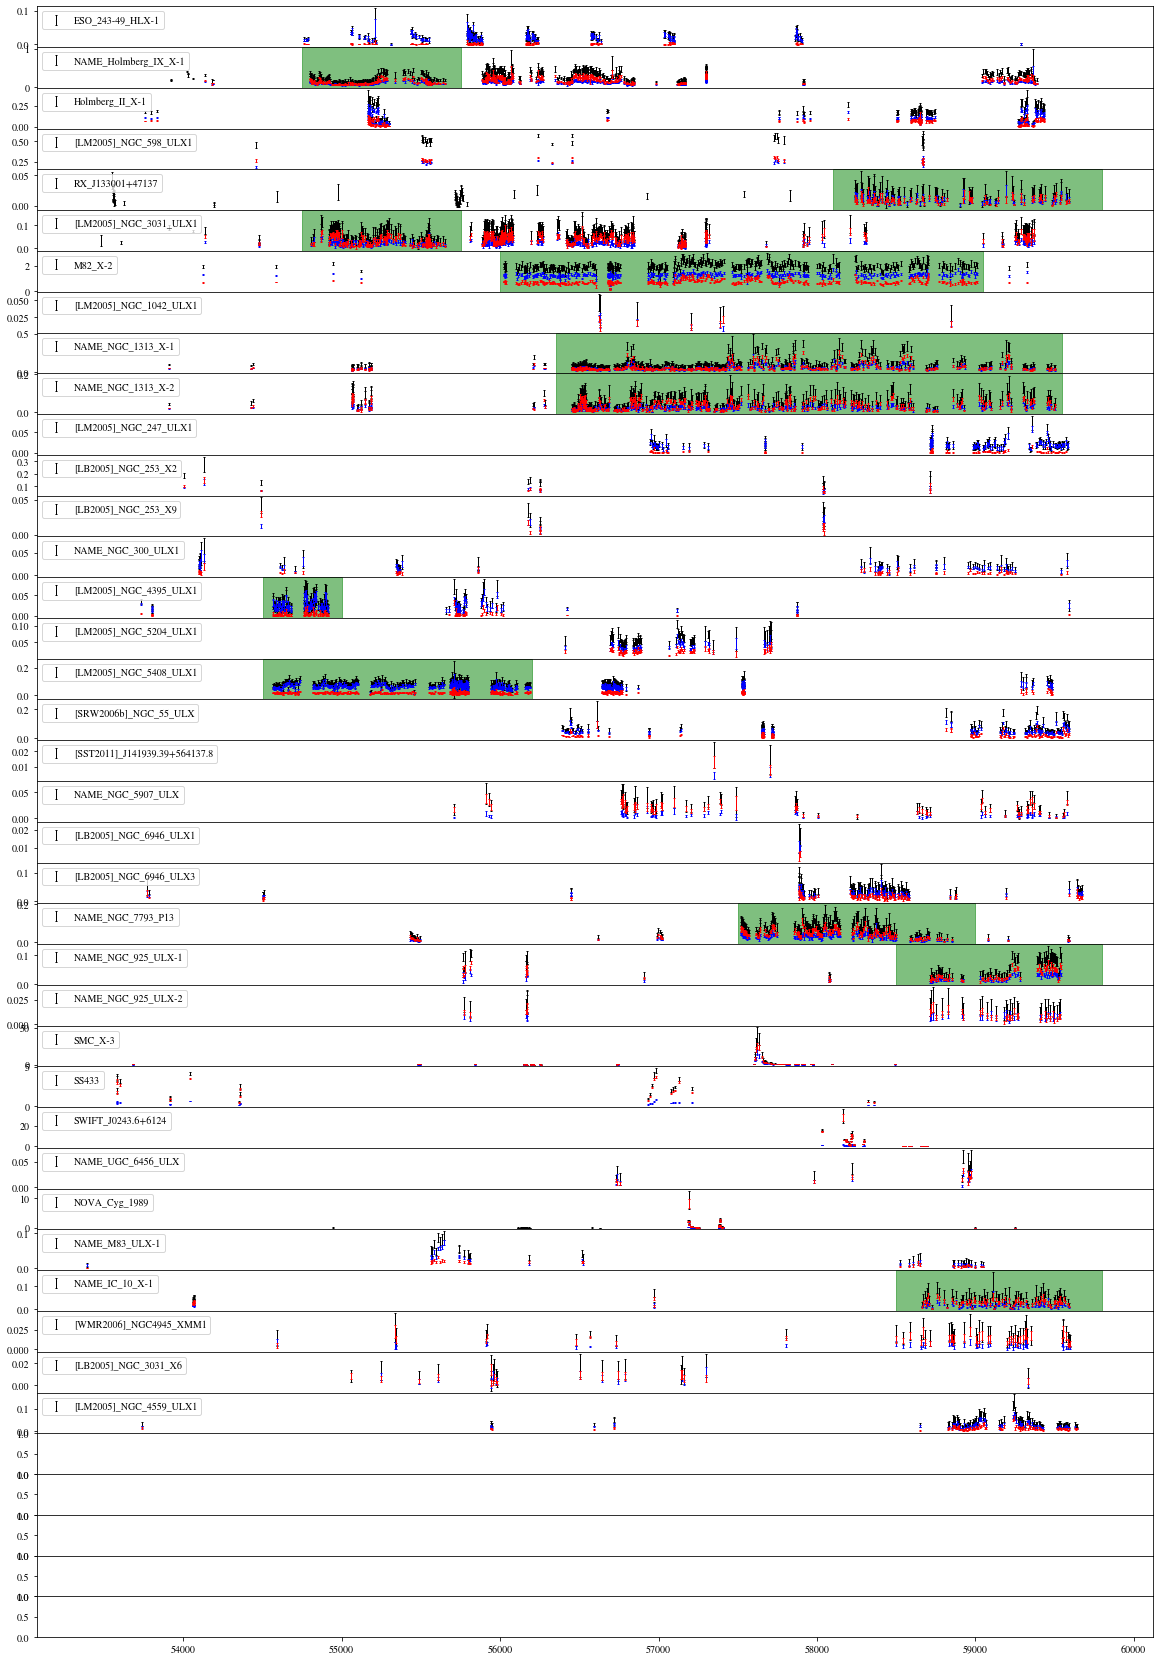

In [11]:
import warnings
from tqdm import tqdm
#warnings.filterwarnings('ignore')

fig, ax = plt.subplots(len(all_lcs), 1, figsize=(20,30), sharex=True)
i=0
for simbad_name, lcs in all_lcs.items():
      
    try:
        tab = lcs['XRT_FULL_PC']
        tab_s = lcs['XRT_SOFT_PC']
        tab_h = lcs['XRT_HARD_PC']
    except:
        continue
    
    try:
        gtis = source_gtis[simbad_name]
        for gti in gtis:
            ax[i].axvspan(gti[0], gti[1], alpha=0.5, color='green')
            
            sub = tab[['MJD', 'RATE', 'RATE_ERR']]
            sub_s = tab_s[['MJD', 'RATE', 'RATE_ERR']]
            sub_h = tab_h[['MJD', 'RATE', 'RATE_ERR']]
            
            sub.write(f'../lightcurves/for_dauser/{simbad_name}_FULL_{gti[0]}_{gti[1]}.csv')
            sub_s.write(f'../lightcurves/for_dauser/{simbad_name}_SOFT_{gti[0]}_{gti[1]}.csv')
            sub_h.write(f'../lightcurves/for_dauser/{simbad_name}_HARD_{gti[0]}_{gti[1]}.csv')
    except:
        pass
            
    

    tab['MJD_0'] = tab['MJD'] - tab['MJD'].min()
    #ax[i].errorbar(tab['MJD_0'], tab['RATE'], yerr=tab['RATE_ERR'], label=simbad_name, ls='none', lw=1.0, capsize=1.0)
    ax[i].errorbar(tab['MJD'], tab['RATE'], yerr=tab['RATE_ERR'], label=simbad_name, ls='none', lw=1.0, capsize=1.0, color='black')
    ax[i].errorbar(tab_s['MJD'], tab_s['RATE'], yerr=tab_s['RATE_ERR'], ls='none', lw=1.0, capsize=1.0, color='blue')
    ax[i].errorbar(tab_h['MJD'], tab_h['RATE'], yerr=tab_h['RATE_ERR'], ls='none', lw=1.0, capsize=1.0, color='red')
    
    ax[i].legend(loc='upper left')
    i+=1
    
plt.subplots_adjust(hspace=0)

KeyError: 'XRT_FULL_PC'

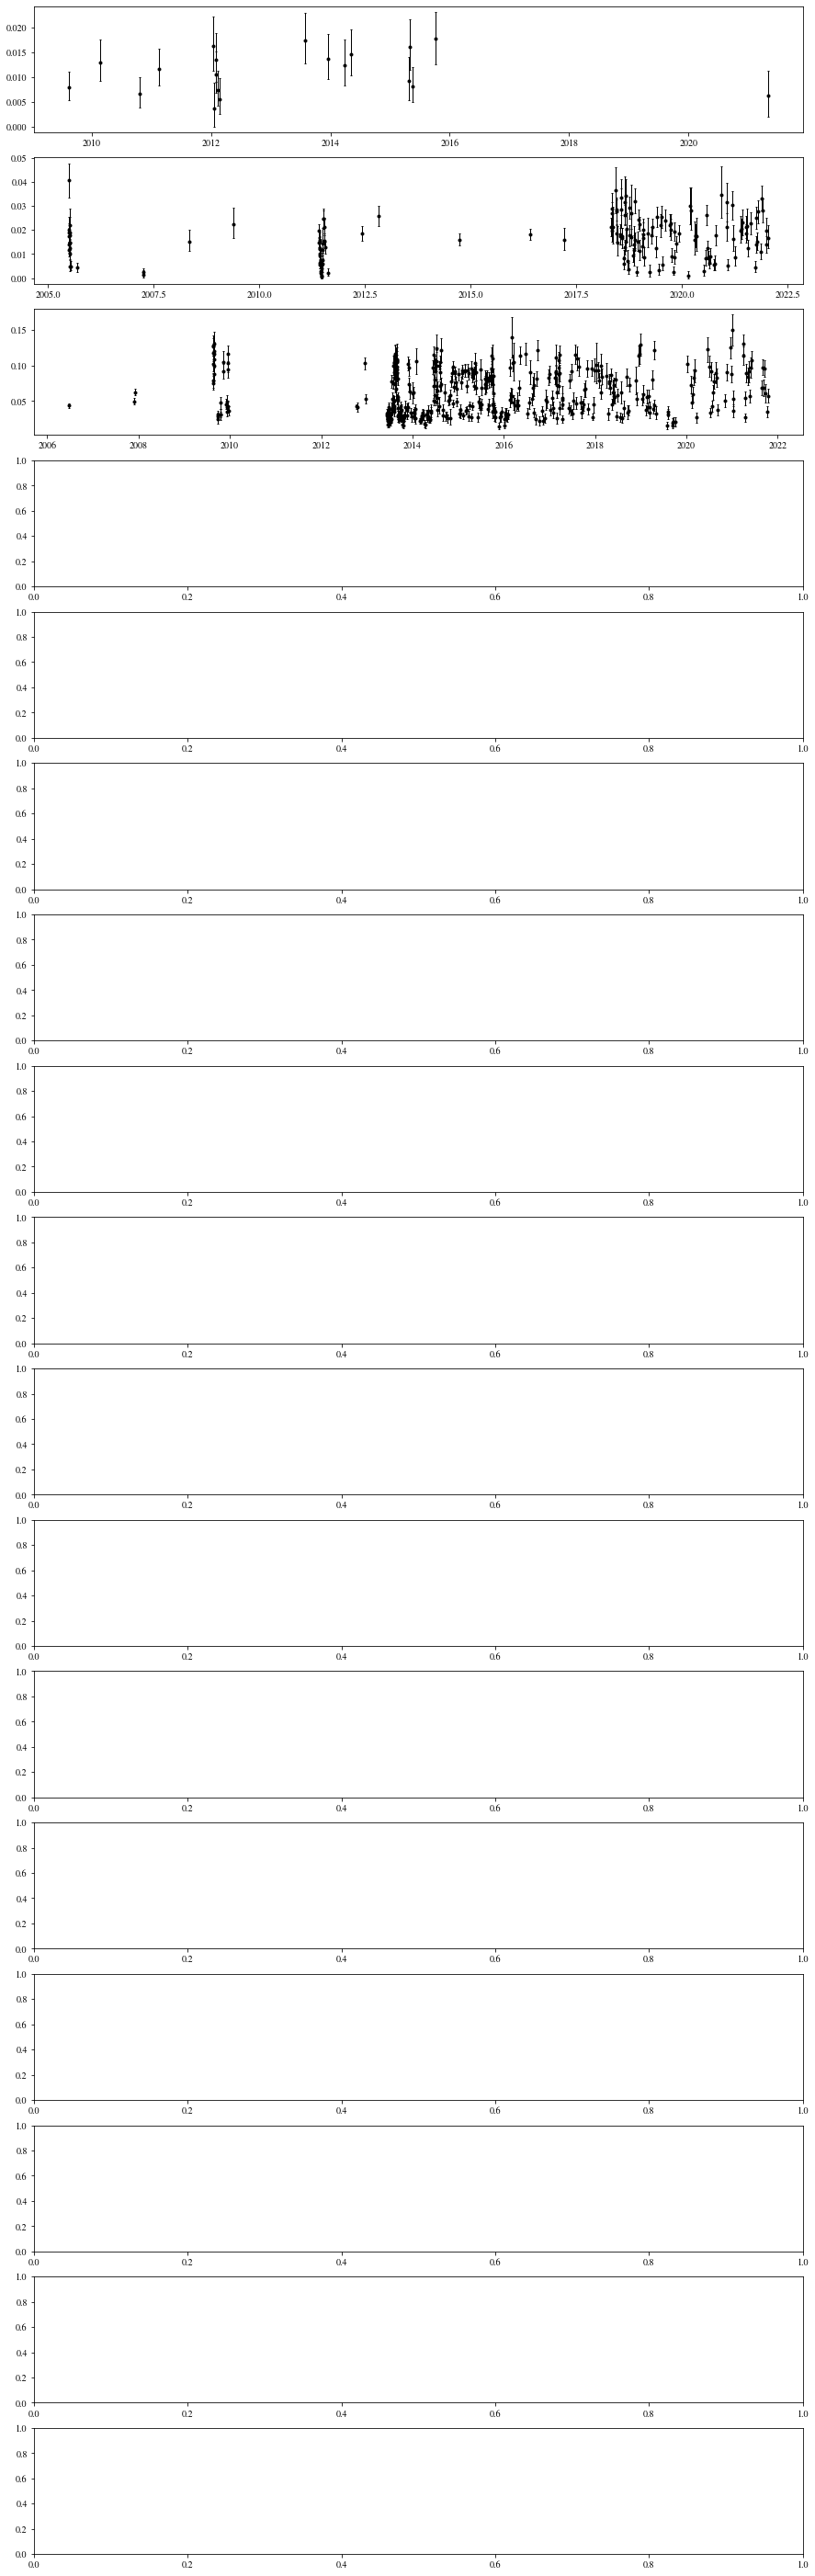

In [12]:
nplot = len(source_names_w_counterparts)
fig, ax = plt.subplots(nplot,1, figsize=(15,3*len(source_names_w_counterparts)))

for i, s in enumerate(source_names_w_counterparts):
    tab = all_lcs[s]['XRT_FULL_PC']
    tab['YEAR'] = Time(tab['MJD'], format='mjd').to_value(format='decimalyear')
    ax[i].errorbar(tab['YEAR'], tab['RATE'], yerr=(np.abs(tab['RATE_ERR_NEG']), tab['RATE_ERR_POS']), ls='none', lw=1.0, capsize=1.0, marker='.', color='black', label=source_names_readable[s])
    
for a in ax:
    a.set_ylabel('Count Rate (0.3 - 10.0 keV)')
    a.set_xlabel('Year')
    a.legend(loc='upper left', prop={'size': 15})
ax[0].set_xlim(2013)
ax[1].set_xlim(2008.8,2016)
ax[2].set_xlim(2012,2021)
ax[3].set_xlim(2016,2020)

plt.tight_layout()
plt.savefig('../figures/swift_lcs.png', facecolor='white')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for simbad_name, lcs in all_lcs.items():
    for xrt_key in ['XRT_FULL_PC', 'XRT_SOFT_PC', 'XRT_HARD_PC', 'XRT_HR_PC']:
        try:
            tab_xrt  = lcs[xrt_key]
        except:
            continue

        for lc_name, tab in lcs.items():
            N_OBS = len(np.unique(tab['OBSID']))
            if 'UVOT' in lc_name:

                tab_uvot = lcs[lc_name]
                if len(tab_uvot) < 30:
                    continue
                tab_uvot = tab_uvot.group_by('OBSID').groups.aggregate(np.mean) # Calculate the mean for duplicated groups
                #tab_uvot  = unique(tab_uvot, keys='OBSID')    # Remove duplicate observation IDS
                tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
                try:
                    tab_join = tab_join[~tab_join['RATE'].mask]
                except:
                    pass
                
                if len(tab_join) < 10:
                    continue

                from scipy.optimize import curve_fit
                from scipy.stats import pearsonr

                def line(x, m, c):
                    return m*x+c

                p_opt, p_cov = curve_fit(line, tab_join['AB_MAG'], tab_join['RATE'])
                r, p_val = pearsonr(tab_join['AB_MAG'], tab_join['RATE'])

                # Plotting
                fig, ax = plt.subplots(1,2, figsize=(25,5), gridspec_kw={'width_ratios': [4, 1]})

                ax[0].set_title(f'{simbad_name} | {xrt_key} | {lc_name} | {len(tab_join)}')
                ax[0].errorbar(tab_join['MJD'], tab_join['AB_MAG'], yerr=tab_join['AB_MAG_ERR'], ls='none', lw=1.0, capsize=1.0, marker='.', color='darkviolet')

                ax2 = ax[0].twinx()
                ax[0].invert_yaxis()
                ax2.errorbar(tab_join['MJD'], tab_join['RATE'], yerr=tab_join['RATE_ERR'], ls='none', lw=1.0, capsize=1.0, marker='.', color='black')
                ax[0].set_ylabel(f'{lc_name} AB MAG (mag)')
                ax[0].set_xlabel('MJD2000')
                ax2.set_ylabel('XRT RATE (ct/s)')

                ax[1].set_title(f'{simbad_name} | {xrt_key} | {lc_name} | {len(tab_join)} \n m={p_opt[0]:.2e} c={p_opt[1]:.2f} r={r:.2f} p_val={p_val:.2f}')
                ax[1].scatter(tab_join['AB_MAG'], tab_join['RATE'], marker='x', color='black')
                ax[1].set_xlabel('AB_MAG')
                xlow, xhigh = ax[1].get_xlim()
                xrange = np.linspace(xlow, xhigh, 100)
                ax[1].plot(xrange, line(xrange, *p_opt), color='red')
                plt.tight_layout()
                plt.savefig(f'../figures/{simbad_name}_{xrt_key}_{lc_name}_lc_unbinned_corr.png', facecolor='white')

                plt.show()


In [ ]:
import warnings
#warnings.filterwarnings('ignore')

uvot_key = 'CORR_RATE'
uvot_key_err = 'CORR_RATE_ERR'

for simbad_name, lcs in all_lcs.items():
    for xrt_key in ['XRT_FULL_PC', 'XRT_SOFT_PC', 'XRT_HARD_PC', 'XRT_HR_PC']:
        try:
            tab_xrt  = lcs[xrt_key]
        except:
            continue

        for lc_name, tab in lcs.items():
            N_OBS = len(np.unique(tab['OBSID']))
            if 'UVOT' in lc_name:

                tab_uvot = lcs[lc_name]
                if len(tab_uvot) < 30:
                    continue
                tab_uvot = tab_uvot.group_by('OBSID').groups.aggregate(np.mean) # Calculate the mean for duplicated groups
                #tab_uvot  = unique(tab_uvot, keys='OBSID')    # Remove duplicate observation IDS
                tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
                try:
                    tab_join = tab_join[~tab_join['RATE'].mask]
                except:
                    pass
                
                if len(tab_join) < 30:
                    print(simbad_name, lc_name, len(tab_join))
                    continue
                    

                def line(x, m, c):
                    return m*x+c

                p_opt, p_cov = curve_fit(line, tab_join[uvot_key], tab_join['RATE'])
                r, p_val = pearsonr(tab_join[uvot_key], tab_join['RATE'])

                # Plotting
                fig, ax = plt.subplots(1,2, figsize=(25,5), gridspec_kw={'width_ratios': [4, 1]})

                ax[0].set_title(f'{simbad_name} | {xrt_key} | {lc_name} | {len(tab_join)}')
                ax[0].errorbar(tab_join['MJD'], tab_join[uvot_key], yerr=tab_join[uvot_key_err], ls='none', lw=1.0, capsize=1.0, marker='.', color='darkviolet')

                ax2 = ax[0].twinx()
                # ax[0].invert_yaxis()
                ax2.errorbar(tab_join['MJD'], tab_join['RATE'], yerr=tab_join['RATE_ERR'], ls='none', lw=1.0, capsize=1.0, marker='.', color='black')
                ax[0].set_ylabel(f'{lc_name} {uvot_key} ({tab_uvot[uvot_key].unit})')
                ax[0].set_xlabel('MJD2000')
                ax2.set_ylabel('XRT RATE (ct/s)')

                ax[1].set_title(f'{simbad_name} | {xrt_key} | {lc_name} | {len(tab_join)} \n m={p_opt[0]:.2e} c={p_opt[1]:.2f} r={r:.2f} p_val={p_val:.2f}')
                ax[1].scatter(tab_join[uvot_key], tab_join['RATE'], marker='x', color='black')
                ax[1].set_xlabel(uvot_key)
                xlow, xhigh = ax[1].get_xlim()
                xrange = np.linspace(xlow, xhigh, 100)
                ax[1].plot(xrange, line(xrange, *p_opt), color='red')
                plt.tight_layout()
                #plt.savefig(f'../figures/{simbad_name}_{xrt_key}_{lc_name}_lc_corr.png')

                plt.show()


In [ ]:
tab = join(all_lcs['NAME_NGC_1313_X-1']['XRT_FULL_PC'], all_lcs['NAME_NGC_1313_X-1']['UVOT_U'], keys='OBSID', join_type='inner')
tab

In [ ]:
tab = tab[tab['AB_MAG'] < 18.5]
tab = tab[tab['AB_MAG'] > 17.00]
tab = tab[tab['RATE'] > 0.01]

plt.figure(figsize=(6,6))
plt.scatter(tab['RATE'], tab['AB_MAG'])

In [ ]:
bin_low  = tab['RATE'].min()
bin_high = tab['RATE'].max()
nbins = 10
rate_bins = np.linspace(bin_low, bin_high, nbins)
bin_step = (bin_high - bin_low) / nbins
rate_bins

In [ ]:
all_rows = []
for bin_low in rate_bins:
    row = {}
    bin_high = bin_low + bin_step
    sub = tab[(tab['RATE'] > bin_low) & (tab['RATE'] < bin_high)]
    n = len(sub)
    rate_mean = np.mean(sub['RATE'])
    rate_sigma = np.std(sub['RATE'])
    rate_se  =  rate_sigma / n
    
    mag_mean = np.mean(sub['AB_MAG'])
    mag_sigma = np.std(sub['AB_MAG'])
    mag_se = mag_sigma / n
    #print(f'{bin_low:<.2f} {bin_high:<.2f} {bin_step:<5} {n:<5} {rate_mean:.4f} {rate_sigma:.4f} {rate_se:.4f}')
    
    row['rate_bin_low'] = bin_low
    row['rate_bin_high'] = bin_high
    row['rate_bin_step'] = bin_step
    row['rate_n_bins'] = nbins
    row['rate_bin_step'] = bin_step
    
    
    row['n'] = n
    row['rate_mean'] = rate_mean
    row['rate_sigma'] = rate_sigma
    row['rate_se'] = rate_se
    row['mag_mean'] = mag_mean
    row['mag_sigma'] = mag_sigma
    row['mag_se'] = mag_se
    all_rows.append(row)
    

df = pd.DataFrame(all_rows)
print(df)

plt.figure(figsize=(6,6))
plt.errorbar(df['rate_mean'], df['mag_mean'], xerr=df['rate_sigma'], yerr=df['mag_sigma'], ls='none', lw=1.0, capsize=1.0)
plt.figure(figsize=(6,6))
plt.errorbar(df['rate_mean'], df['mag_mean'], xerr=df['rate_se'], yerr=df['mag_se'], ls='none', lw=1.0, capsize=1.0)


In [ ]:
import warnings
#warnings.filterwarnings('ignore')

uvot_key = 'CORR_RATE'
uvot_key_err = 'CORR_RATE_ERR'

for simbad_name, lcs in all_lcs.items():
    for xrt_key in ['XRT_FULL_PC', 'XRT_SOFT_PC', 'XRT_HARD_PC', 'XRT_HR_PC']:
        row = {}
        try:
            tab_xrt  = lcs[xrt_key]
        except:
            continue

        for lc_name, tab in lcs.items():
            N_OBS = len(np.unique(tab['OBSID']))
            if 'UVOT' in lc_name:

                tab_uvot = lcs[lc_name]
                if len(tab_uvot) < 30:
                    continue
                tab_uvot = tab_uvot.group_by('OBSID').groups.aggregate(np.mean) # Calculate the mean for duplicated groups
                #tab_uvot  = unique(tab_uvot, keys='OBSID')    # Remove duplicate observation IDS
                tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
                try:
                    tab_join = tab_join[~tab_join['RATE'].mask]
                except:
                    pass
                
                if len(tab_join) < 30:
                    continue

                def line(x, m, c):
                    return m*x+c

                bin_low  = tab_join['RATE'].min()
                bin_high = tab_join['RATE'].max()
                nbins = 10
                rate_bins = np.linspace(bin_low, bin_high, nbins)
                bin_step = (bin_high - bin_low) / nbins
                
                all_rows = []
                
                for bin_low in rate_bins:
                    row = {}
                    bin_high = bin_low + bin_step
                    sub = tab_join[(tab_join['RATE'] > bin_low) & (tab_join['RATE'] < bin_high)]
                    n = len(sub)
                    rate_mean = np.mean(sub['RATE'])
                    rate_sigma = np.std(sub['RATE'])
                    rate_se  =  rate_sigma / np.sqrt(n)

                    mag_mean = np.mean(sub['AB_MAG'])
                    mag_sigma = np.std(sub['AB_MAG'])
                    mag_se = mag_sigma / np.sqrt(n)
                    
                    row['rate_bin_low'] = bin_low
                    row['rate_bin_high'] = bin_high
                    row['rate_bin_step'] = bin_step
                    row['rate_n_bins'] = nbins
                    row['rate_bin_step'] = bin_step

                    row['n'] = n
                    row['rate_mean'] = rate_mean
                    row['rate_sigma'] = rate_sigma
                    row['rate_se'] = rate_se
                    row['mag_mean'] = mag_mean
                    row['mag_sigma'] = mag_sigma
                    row['mag_se'] = mag_se
                    all_rows.append(row)
                
                df = pd.DataFrame(all_rows)
                df_fit = df[df['n'] != 0]
                #print(df)
                if len(df_fit) > 1:
                    p_opt1, p_cov1 = curve_fit(line, df_fit['rate_mean'], df_fit['mag_mean'], sigma=df_fit['mag_sigma'])
                    p_opt2, p_cov2 = curve_fit(line, df_fit['rate_mean'], df_fit['mag_mean'], sigma=df_fit['mag_se'])

                    r, p_val = pearsonr(df_fit['rate_mean'], df_fit['mag_mean'])
                else:
                    p_opt1[0] = 1.00
                    

                fig, ax = plt.subplots(1,2, figsize=(12,6))

                ax[0].set_title(f'{simbad_name} | {xrt_key} | {lc_name} | {len(tab_join)} | $\sigma$ \n r={r:.3f} p_val={p_val:.3f}')
                ax[1].set_title(f'{simbad_name} | {xrt_key} | {lc_name} | {len(tab_join)} | $SE$ \n r={r:.3f} p_val={p_val:.3f}')
                ax[0].set_xlabel('XRT RATE')
                ax[0].set_ylabel('AB MAG')
                
                ax[0].scatter(tab_join['RATE'], tab_join['AB_MAG'], marker='x', color='grey', alpha=0.8)
                ax[1].scatter(tab_join['RATE'], tab_join['AB_MAG'], marker='x', color='grey', alpha=0.8)
                
                ax[0].errorbar(df['rate_mean'], df['mag_mean'], xerr=df['rate_sigma'], yerr=df['mag_sigma'], ls='none', lw=1.0, capsize=1.0, color='black')
                ax[1].errorbar(df['rate_mean'], df['mag_mean'], xerr=df['rate_se'], yerr=df['mag_se'], ls='none', lw=1.0, capsize=1.0, color='black')
                
                xlow, xhigh = ax[0].get_xlim()
                xrange = np.linspace(xlow, xhigh, 100)
                if p_opt1[0]!=1.00:
                    ax[0].plot(xrange, line(xrange, p_opt1[0], p_opt1[1]), color='red', label=f'y={p_opt1[0]:.2f}x+{p_opt1[1]:.2f}')
                    ax[1].plot(xrange, line(xrange, p_opt2[0], p_opt2[1]), color='red', label=f'y={p_opt2[0]:.2f}x+{p_opt2[1]:.2f}')
                    ax[0].legend()
                    ax[1].legend()
                
                ax[0].set_xlim(xlow, xhigh)
                ax[1].set_xlim(xlow, xhigh)
                
                
                #ax[0].invert_yaxis()
                #ax[1].invert_yaxis()
                plt.savefig(f'../figures/{simbad_name}_{xrt_key}_{lc_name}_corr_binned.png', facecolor='white')
                plt.show()
                

In [ ]:
from astropy.units import day
from statsmodels.tsa.stattools import ccf

In [ ]:
plt.plot(all_lcs['NAME_Holmberg_IX_X-1']['XRT_FULL_PC']['MJD'] , all_lcs['NAME_Holmberg_IX_X-1']['XRT_FULL_PC']['RATE'])

In [ ]:
gtis = [(56000,56800),
        (59000,62000),
        ]

for gti in gtis:
    tab_xrt = all_lcs['NAME_Holmberg_IX_X-1']['XRT_FULL_PC']
    tab_uvot  = all_lcs['NAME_Holmberg_IX_X-1']['UVOT_UVW2']
    
    tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
    
    sub = tab_join[(tab_join['MJD'] > gti[0]) & (tab_join['MJD'] < gti[1])]
    
    
    fig = plt.figure(figsize=(25,10), constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=4, ncols=4, left=0.07, right=0.48, wspace=0.05)
    ax1 = fig.add_subplot(gs1[:2, :4])
    ax2 = fig.add_subplot(gs1[-2, :-1])
    ax3 = fig.add_subplot(gs1[-2, -1])
    ax4 = fig.add_subplot(gs1[3,3])
    ax5 = fig.add_subplot(gs1[3:,2:3])

    ax1.errorbar(sub['MJD'], sub['RATE'], yerr=(np.abs(sub['RATE_ERR_NEG']), sub['RATE_ERR_POS']), marker='.', ls='none', lw=1.0, capsize=1.0, color='black')
    ax1_t = ax1.twinx()
    ax1_t.errorbar(sub['MJD'], sub['MAG'], yerr=sub['MAG_ERR'], marker='.', ls='none', lw=1.0, capsize=1.0, color='darkviolet')

    freq_uv, power_uv = LombScargle(sub['MJD'], sub['MAG']).autopower(minimum_frequency=0.07)
    freq_xrt, power_xrt = LombScargle(sub['MJD'], sub['RATE']).autopower(minimum_frequency=0.07)
    f_max_uv = freq_uv[power_uv.argmax()]
    f_max_xrt = freq_xrt[power_xrt.argmax()]
    
    ax2.plot(freq_uv, power_uv, lw=1.0, color='darkviolet')
    ax2.axvline(f_max_uv, color='red', ls='--', lw=2.0)
    ax2_1 = ax2.twinx()
    ax2_1.plot(freq_xrt, power_xrt, lw=1.0, color='black')
    ax2_1.axvline(f_max_xrt, color='grey', ls='--', lw=2.0)
    
    
    ax3.plot(ccf(sub['RATE'], sub['MAG']))
    ax3.plot(ccf(sub['MAG'], sub['RATE']))
    
    ax4.hist(sub['MAG'], histtype='step', color='darkviolet', bins=20)
    ax4_1 = ax4.twiny()
    ax4_1.hist(sub['RATE'], histtype='step', color='black', bins=20)
    
    ax5.scatter(sub['RATE'], sub['MAG'], c=range(len(sub)), s=4.0, marker='s')
    #ax5.loglog()
    
    


In [ ]:
gtis = 

for gti in gtis:
    tab_xrt   = all_lcs[]['XRT_FULL_PC']
    tab_uvot  = all_lcs['NAME_NGC_1313_X-1']['UVOT_UVW2']
    
    tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
    
    sub = tab_join[(tab_join['MJD'] > gti[0]) & (tab_join['MJD'] < gti[1])]
    
    
    fig = plt.figure(figsize=(25,10), constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=4, ncols=4, left=0.07, right=0.48, wspace=0.05)
    ax1 = fig.add_subplot(gs1[:2, :4])
    ax2 = fig.add_subplot(gs1[-2, :-1])
    ax3 = fig.add_subplot(gs1[-2, -1])
    ax4 = fig.add_subplot(gs1[3,3])
    ax5 = fig.add_subplot(gs1[3:,2:3])

    ax1.errorbar(sub['MJD'], sub['RATE'], yerr=(np.abs(sub['RATE_ERR_NEG']), sub['RATE_ERR_POS']), marker='.', ls='none', lw=1.0, capsize=1.0, color='black')
    ax1_t = ax1.twinx()
    ax1_t.errorbar(sub['MJD'], sub['MAG'], yerr=sub['MAG_ERR'], marker='.', ls='none', lw=1.0, capsize=1.0, color='darkviolet')

    freq_uv, power_uv = LombScargle(sub['MJD'], sub['MAG']).autopower(minimum_frequency=0.07)
    freq_xrt, power_xrt = LombScargle(sub['MJD'], sub['RATE']).autopower(minimum_frequency=0.07)
    f_max_uv = freq_uv[power_uv.argmax()]
    f_max_xrt = freq_xrt[power_xrt.argmax()]
    
    ax2.plot(freq_uv, power_uv, lw=1.0, color='darkviolet')
    ax2.axvline(f_max_uv, color='red', ls='--', lw=2.0)
    ax2_1 = ax2.twinx()
    ax2_1.plot(freq_xrt, power_xrt, lw=1.0, color='black')
    ax2_1.axvline(f_max_xrt, color='grey', ls='--', lw=2.0)
    
    
    ax3.plot(ccf(sub['RATE'], sub['MAG']))
    ax3.plot(ccf(sub['MAG'], sub['RATE']))
    
    ax4.hist(sub['MAG'], histtype='step', color='darkviolet', bins=20)
    ax4_1 = ax4.twiny()
    ax4_1.hist(sub['RATE'], histtype='step', color='black', bins=20)
    
    ax5.scatter(sub['RATE'], sub['MAG'], c=range(len(sub)), s=4.0, marker='s')
    ax5.loglog()
    
    


In [ ]:

for gti in gtis:
    tab_xrt   = all_lcs['[LM2005]_NGC_5408_ULX1']['XRT_FULL_PC']
    tab_uvot  = all_lcs['[LM2005]_NGC_5408_ULX1']['UVOT_UVM2']
    
    tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
    
    sub = tab_join[(tab_join['MJD'] > gti[0]) & (tab_join['MJD'] < gti[1])]
    
    
    fig = plt.figure(figsize=(25,10), constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=4, ncols=4, left=0.07, right=0.48, wspace=0.05)
    ax1 = fig.add_subplot(gs1[:2, :4])
    ax2 = fig.add_subplot(gs1[-2, :-1])
    ax3 = fig.add_subplot(gs1[-2, -1])
    ax4 = fig.add_subplot(gs1[3,3])
    ax5 = fig.add_subplot(gs1[3:,2:3])

    ax1.errorbar(sub['MJD'], sub['RATE'], yerr=(np.abs(sub['RATE_ERR_NEG']), sub['RATE_ERR_POS']), marker='.', ls='none', lw=1.0, capsize=1.0, color='black')
    ax1_t = ax1.twinx()
    ax1_t.errorbar(sub['MJD'], sub['MAG'], yerr=sub['MAG_ERR'], marker='.', ls='none', lw=1.0, capsize=1.0, color='darkviolet')

    freq_uv, power_uv = LombScargle(sub['MJD'], sub['MAG']).autopower(minimum_frequency=0.07)
    freq_xrt, power_xrt = LombScargle(sub['MJD'], sub['RATE']).autopower(minimum_frequency=0.07)
    f_max_uv = freq_uv[power_uv.argmax()]
    f_max_xrt = freq_xrt[power_xrt.argmax()]
    
    ax2.plot(freq_uv, power_uv, lw=1.0, color='darkviolet')
    ax2.axvline(f_max_uv, color='red', ls='--', lw=2.0)
    ax2_1 = ax2.twinx()
    ax2_1.plot(freq_xrt, power_xrt, lw=1.0, color='black')
    ax2_1.axvline(f_max_xrt, color='grey', ls='--', lw=2.0)
    
    
    ax3.plot(ccf(sub['RATE'], sub['MAG']))
    ax3.plot(ccf(sub['MAG'], sub['RATE']))
    
    ax4.hist(sub['MAG'], histtype='step', color='darkviolet', bins=20)
    ax4_1 = ax4.twiny()
    ax4_1.hist(sub['RATE'], histtype='step', color='black', bins=20)
    
    ax5.scatter(sub['RATE'], sub['MAG'], c=range(len(sub)), s=4.0, marker='s')
    ax5.loglog()
    
    


In [ ]:
gtis = 

for gti in gtis:
    tab_xrt   = all_lcs[]['XRT_FULL_PC']
    tab_uvot  = all_lcs['[LM2005]_NGC_4395_ULX1']['UVOT_B']
    
    tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
    
    sub = tab_join[(tab_join['MJD'] > gti[0]) & (tab_join['MJD'] < gti[1])]
    
    
    fig = plt.figure(figsize=(25,10), constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=4, ncols=4, left=0.07, right=0.48, wspace=0.05)
    ax1 = fig.add_subplot(gs1[:2, :4])
    ax2 = fig.add_subplot(gs1[-2, :-1])
    ax3 = fig.add_subplot(gs1[-2, -1])
    ax4 = fig.add_subplot(gs1[3,3])
    ax5 = fig.add_subplot(gs1[3:,2:3])

    ax1.errorbar(sub['MJD'], sub['RATE'], yerr=(np.abs(sub['RATE_ERR_NEG']), sub['RATE_ERR_POS']), marker='.', ls='none', lw=1.0, capsize=1.0, color='black')
    ax1_t = ax1.twinx()
    ax1_t.errorbar(sub['MJD'], sub['MAG'], yerr=sub['MAG_ERR'], marker='.', ls='none', lw=1.0, capsize=1.0, color='darkviolet')

    freq_uv, power_uv = LombScargle(sub['MJD'], sub['MAG']).autopower(minimum_frequency=0.07)
    freq_xrt, power_xrt = LombScargle(sub['MJD'], sub['RATE']).autopower(minimum_frequency=0.07)
    f_max_uv = freq_uv[power_uv.argmax()]
    f_max_xrt = freq_xrt[power_xrt.argmax()]
    
    ax2.plot(freq_uv, power_uv, lw=1.0, color='darkviolet')
    
    ax2_1 = ax2.twinx()
    ax2_1.plot(freq_xrt, power_xrt, lw=1.0, color='black')
    
    ax2.axvline(f_max_uv, color='red', ls='--', lw=2.0, label=f'UV = {f_max_uv:.3f} days^-1')
    ax2_1.axvline(f_max_xrt, color='grey', ls='--', lw=2.0, label=f'XRT {f_max_xrt:.3f} days^-1')
    ax2.legend()
    ax2_1.legend()
    
    
    ax3.plot(ccf(sub['RATE'], sub['MAG']))
    ax3.plot(ccf(sub['MAG'], sub['RATE']))
    
    ax4.hist(sub['MAG'], histtype='step', color='darkviolet', bins=20)
    ax4_1 = ax4.twiny()
    ax4_1.hist(sub['RATE'], histtype='step', color='black', bins=20)
    
    ax5.scatter(sub['RATE'], sub['MAG'], c=range(len(sub)), s=4.0, marker='s')
    ax5.loglog()
    
    


In [ ]:
gtis = 

for gti in gtis:
    tab_xrt   = all_lcs['NAME_IC_10_X-1']['XRT_FULL_PC']
    tab_uvot  = all_lcs['NAME_IC_10_X-1']['UVOT_U']
    
    tab_join = join(tab_uvot, tab_xrt , join_type='inner', keys='OBSID')
    
    sub = tab_join[(tab_join['MJD'] > gti[0]) & (tab_join['MJD'] < gti[1])]
    
    
    fig = plt.figure(figsize=(25,10), constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=4, ncols=4, left=0.07, right=0.48, wspace=0.05)
    ax1 = fig.add_subplot(gs1[:2, :4])
    ax2 = fig.add_subplot(gs1[-2, :-1])
    ax3 = fig.add_subplot(gs1[-2, -1])
    ax4 = fig.add_subplot(gs1[3,3])
    ax5 = fig.add_subplot(gs1[3:,2:3])

    ax1.errorbar(sub['MJD'], sub['RATE'], yerr=(np.abs(sub['RATE_ERR_NEG']), sub['RATE_ERR_POS']), marker='.', ls='none', lw=1.0, capsize=1.0, color='black')
    ax1_t = ax1.twinx()
    ax1_t.errorbar(sub['MJD'], sub['MAG'], yerr=sub['MAG_ERR'], marker='.', ls='none', lw=1.0, capsize=1.0, color='darkviolet')

    ls_uv  = LombScargle(sub['MJD'], sub['MAG'], sub['MAG_ERR'])
    ls_xrt = LombScargle(sub['MJD'], sub['RATE'], sub['RATE_ERR'])
    
    freq_uv, power_uv = ls_uv.autopower(minimum_frequency=0.07)
    freq_xrt, power_xrt = ls_xrt.autopower(minimum_frequency=0.07)
    
    f_max_uv = freq_uv[power_uv.argmax()]
    f_max_xrt = freq_xrt[power_xrt.argmax()]
    
    ax2.plot(freq_uv, power_uv, lw=1.0, color='darkviolet')
    
    ax2_1 = ax2.twinx()
    ax2_1.plot(freq_xrt, power_xrt, lw=1.0, color='black')
    ax2.axvline(f_max_uv, color='red', ls='--', lw=2.0, label=f'UV = {f_max_uv:.3f}  days^-1')
    ax2_1.axvline(f_max_xrt, color='grey', ls='--', lw=2.0, label=f'XRT {f_max_xrt:.3f}  days^-1')
    ax2.legend()
    ax2_1.legend()
    
    
    ax3.plot(ccf(sub['RATE'], sub['MAG']))
    ax3.plot(ccf(sub['MAG'], sub['RATE']))
    
    ax4.hist(sub['MAG'], histtype='step', color='darkviolet', bins=20)
    ax4_1 = ax4.twiny()
    ax4_1.hist(sub['RATE'], histtype='step', color='black', bins=20)
    
    ax5.scatter(sub['RATE'], sub['MAG'], c=range(len(sub)), s=4.0, marker='s')
    ax5.loglog()
    
    


In [ ]:
for key, lcs in all_lcs.items():
    for lc_key, lc in lcs.items():
        fn = f'{key}_{lc_key}.csv'
        
        if len(lc) > 50:
            if 'XRT' in lc_key:
                sub = lc[['MJD', 'RATE', 'RATE_ERR']]
            elif 'UVOT' in lc_key:
                lc['MJD'] = 51910 + lc['MET'] / 86400.0
                sub = lc[['MJD', 'MAG', 'MAG_ERR']]
                sub.rename_column('MAG', 'RATE')
                sub.rename_column('MAG_ERR', 'RATE_ERR')
            sub.write(f'../lightcurves/{fn}', format='csv')
                
            print(fn)
            print(len(lc))

In [ ]:
x,y = LombScargle(sub['MJD'], sub['RATE']).autopower(minimum_frequency=0.05) 
plt.plot(x,y)

In [ ]:
fig8 = plt.figure(figsize=(15,5), constrained_layout=False)
gs1 = fig8.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.05)
f8_ax1 = fig8.add_subplot(gs1[:-1, :])
f8_ax2 = fig8.add_subplot(gs1[-1, :-1])
f8_ax3 = fig8.add_subplot(gs1[-1, -1])

In [ ]:
?LombScargle.autofrequency

In [ ]:
?LombScargle.autopower